In [67]:
import json
import glob
import datetime
import os
import copy
from collections import deque, Counter

import matplotlib.pyplot as plt
import numpy as np

In [68]:
def timestamp_to_hour(timestamp):
    timestamp_time = datetime.datetime.fromtimestamp(timestamp)
    hour_time = 0
    hour_time += timestamp_time.hour
    hour_time += timestamp_time.minute/60
    hour_time += timestamp_time.second/60/60

    return hour_time


def format_timestamp(timestamp):
    agent_time = datetime.datetime.fromtimestamp(timestamp)
    return agent_time.strftime("%H:%M:%S")

In [69]:
output_path = "output"

In [70]:
log_paths = glob.glob("logs\\*.json")

logs = []
for log_path in log_paths:
    with open(log_path) as file:
        logs.append(json.load(file))

In [71]:
logs = sorted(logs, key=lambda log : log["agent_time"])

In [72]:
times = []
sound_intensities = []

for log in logs:
    if "sound_intensity" not in log["sensor_result"]:
        continue

    agent_time = datetime.datetime.fromtimestamp(log["agent_time"])
    hour_time = 0
    hour_time += agent_time.hour
    hour_time += agent_time.minute/60
    hour_time += agent_time.second/60/60
        
    times.append(hour_time)
    sound_intensities.append(log["sensor_result"]["sound_intensity"])

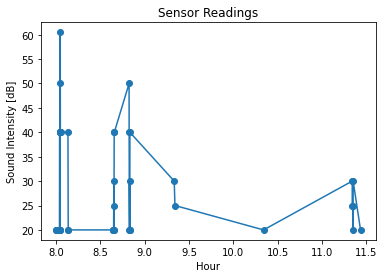

In [73]:
fig = plt.figure()
plt.plot(times, sound_intensities, "o-")

plt.title("Sensor Readings")
plt.xlabel("Hour")
plt.ylabel("Sound Intensity [dB]")

path = os.path.join(output_path, "SensorReadings.png")
fig.savefig(path, facecolor="white", transparent=False)

plt.show()

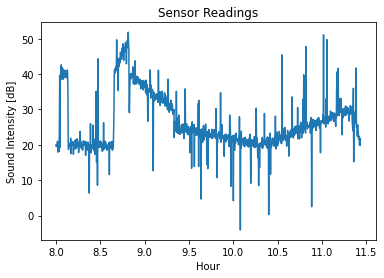

In [113]:
times_linear = np.linspace(timestamp_to_hour(logs[0]["agent_time"]), timestamp_to_hour(logs[-1]["agent_time"]), 1000)
intensities_linear = np.interp(times_linear, times, sound_intensities)

intensities_linear += np.random.normal(0, 1, len(intensities_linear))

super_noise = np.random.uniform(0, 1, len(intensities_linear)) > 0.9
intensities_linear += super_noise*np.random.normal(0, 10, len(intensities_linear))

fig = plt.figure()
plt.plot(times_linear, intensities_linear)

plt.title("Sensor Readings")
plt.xlabel("Hour")
plt.ylabel("Sound Intensity [dB]")

path = os.path.join(output_path, "SensorReadingsInterpolationNoise.png")
fig.savefig(path, facecolor="white", transparent=False)

plt.show()

In [75]:
for intensity in np.unique(sound_intensities)[2:]:
    print(intensity, "dB:",)
    for i in range(len(sound_intensities)):
        if sound_intensities[i] == intensity:
            print(logs[i+1]["action"])

30.0 dB:
Alex sits down in the ergonomic office chair
Alex gets computer and necessary cables ready for editing
Alex continues editing his photos
Alex saves his work on the laptop.
Alex continues editing photos
40.0 dB:
Alex heads to refrigerator_0 to get ingredients for breakfast
Alex opens the refrigerator_0 to get ingredients for breakfast.
Alex gets eggs from the refrigerator_0
Alex goes to refrigerator_0
Alex takes breakfast from refrigerator_0
Alex eats breakfast at dining_table_0
Alex continues eating breakfast at dining_table_0
Alex finishes eating breakfast at dining_table_0
Alex prepares breakfast
Alex continues preparing breakfast
Alex heads to the Home Office
Alex continues editing his photos
50.0 dB:
Alex puts plates on dining_table_0
Alex puts the breakfast on the dining table
60.5 dB:
Alex getsplates_from_cabinet_in_kitchen


In [76]:
path = os.path.join(output_path, "summary.md")
file = open(path, "w")

for log in logs:
    agent_time = datetime.datetime.fromtimestamp(log["agent_time"])
    print(agent_time.strftime("%H:%M:%S"), log["current_place"], file=file)
    print(file=file)

    if "sound_intensity" in log["sensor_result"]:
        print("Sensor reading:", log["sensor_result"]["sound_intensity"], "dB", file=file)
    else:
        print("Sensor reading:", file=file)
    print(file=file)

    print("State:", log["state"], file=file)
    print(file=file)
    print("Observation:", log["curret_observation"], file=file)
    print(file=file)
    print("Next action:", log["action"], file=file)
    print(file=file)
    print("----", file=file)

file.close()

In [77]:
for action in logs[0]["plan"]:
    hour = action["hour"]
    minute = action["minute"]
    action_action = action["action"]

    print(f"{hour}:{minute}: {action_action}")


8:0: Wake up
8:15: Have breakfast
9:0: Get computer and necessary cables ready for editing
9:10: Organize and import yesterday's photos to editing software
9:30: Start editing photos
12:0: Lunch break
13:0: Respond to social media comments
13:20: Post new content
15:0: Continue editing photos
15:10: Continue editing photos
15:20: Continue editing photos
15:30: Continue editing photos
15:40: Continue editing photos
15:50: Continue editing photos
18:0: Take a break
18:10: Read a book
18:30: Have a snack
20:0: Meditate
20:10: Reflect on the day
21:0: Write in journal
22:0: Start winding down
22:10: Begin nighttime routine
22:20: Get into bed


In [78]:
print("First log time")
print(datetime.datetime.fromtimestamp(os.path.getctime(log_paths[0])))
agent_time = datetime.datetime.fromtimestamp(logs[0]["agent_time"])
print("Simulation time:", agent_time.strftime("%H:%M:%S"))

print()

print("Last log time")
print(datetime.datetime.fromtimestamp(os.path.getctime(log_paths[-1])))
agent_time = datetime.datetime.fromtimestamp(logs[-1]["agent_time"])
print("Simulation time:", agent_time.strftime("%H:%M:%S"))

First log time
2024-06-27 13:26:23.358463
Simulation time: 08:00:00

Last log time
2024-06-27 14:59:41.325822
Simulation time: 11:26:04


In [79]:
len(log_paths)

47

In [80]:
memory_stream = copy.deepcopy(logs[-1]["memory_stream"])
n_memory = len(memory_stream)

for memory in memory_stream:
    memory["influences"] = []
    memory["index"] -= 1

    if "because_of" not in memory:
        memory["because_of"] = []

memory_graph = np.zeros((n_memory, n_memory), bool)
for memory in memory_stream:
    for parent in memory["because_of"]:
        memory_graph[parent][memory["index"]] = True

        memory_stream[parent]["influences"].append(memory["index"])

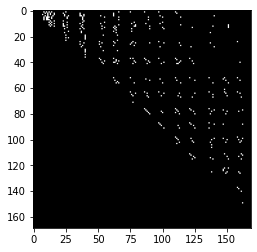

In [81]:
plt.imshow(memory_graph, cmap="gray")

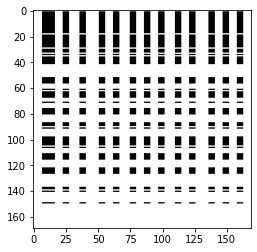

In [82]:
memory_graph_plot = np.zeros_like(memory_graph)

for line in range(len(memory_stream)):
    if memory_graph[:, line].sum() == 0:
        memory_graph_plot[:, line] = 1
    
    if memory_graph[line].sum() == 0:
        memory_graph_plot[line] = 1


plt.imshow(memory_graph_plot, cmap="gray")

In [83]:
influences = np.sum(memory_graph, axis=1)
influenced = np.sum(memory_graph.T, axis=1)

In [84]:
influences_most = np.argmax(influences)
more_influenced = np.argmax(influenced)

influences_most, more_influenced

(4, 62)

In [85]:
memory_stream[influences_most]

{'type': 'reflection',
 'created': 1704106800.0,
 'description': 'Alex is a social butterfly who thrives on meeting new people and making lasting connections.',
 'last_acessed': 1719498058.5,
 'embedding': [],
 'importance': 0.2777777777777778,
 'index': 4,
 'influences': [9, 11, 15, 24, 27, 36, 37, 39, 52, 62, 98, 140],
 'because_of': []}

In [86]:
memory_stream[more_influenced]

{'type': 'reflection',
 'description': 'Alex is a creative and sociable person who is passionate about photography and values comfort and coziness in his personal space',
 'created': 1719486171.0,
 'last_acessed': 1719498058.5,
 'because_of': [2, 3, 4, 13, 16, 24, 27, 37, 40, 52],
 'embedding': [],
 'importance': 0.16666666666666666,
 'index': 62,
 'influences': []}

In [87]:
for parent_index in memory_stream[more_influenced]["because_of"]:
    parent_memory = memory_stream[parent_index]
    print(f"{parent_memory['index']}({parent_memory['type']}, {parent_memory['importance']}): {parent_memory['description']}")

print("---")

print(f"{memory_stream[more_influenced]['index']}({memory_stream[more_influenced]['type']}, {memory_stream[more_influenced]['importance']}): {memory_stream[more_influenced]['description']}")

2(reflection, 0.3333333333333333): Alex enjoys experimenting with different styles and techniques, constantly pushing the boundaries of his creativity.
3(reflection, 0.3333333333333333): Alex has a particular fondness for photographing nature, finding inspiration in the beauty of landscapes, wildlife, and natural light.
4(reflection, 0.2777777777777778): Alex is a social butterfly who thrives on meeting new people and making lasting connections.
13(reflection, 0.1111111111111111): Alex's photography style is shaped by his creative, experimental, and passionate nature.
16(reflection, 0.7222222222222222): Alex's passion for photography is deeply connected to his social and creative personality traits.
24(reflection, 0.16666666666666666): Alex's personality traits have a significant impact on his photography style
27(reflection, 0.6111111111111112): Alex's passion for photography is closely tied to his appreciation for nature
37(reflection, 0.5): Alex's passion for photography is closely 

In [88]:
for parent_index in memory_stream[more_influenced]["because_of"]:
    parent_memory = memory_stream[parent_index]
    for influenced in parent_memory["influences"]:
        if influenced in memory_stream[more_influenced]["because_of"]:
            print(parent_index, "-->", influenced)

    print(parent_index, "-->", more_influenced)

2 --> 13
2 --> 16
2 --> 62
3 --> 13
3 --> 16
3 --> 24
3 --> 62
4 --> 24
4 --> 27
4 --> 37
4 --> 52
4 --> 62
13 --> 62
16 --> 27
16 --> 37
16 --> 62
24 --> 62
27 --> 62
37 --> 62
40 --> 62
52 --> 62


In [89]:
for parent_index in [2, 3, 4]:
    parent_memory = memory_stream[parent_index]
    print(f"{parent_memory['index']}({parent_memory['type']}, {parent_memory['importance']}): {parent_memory['description']}")

print("---")

print(f"{memory_stream[more_influenced]['index']}({memory_stream[more_influenced]['type']}, {memory_stream[more_influenced]['importance']}): {memory_stream[more_influenced]['description']}")

2(reflection, 0.3333333333333333): Alex enjoys experimenting with different styles and techniques, constantly pushing the boundaries of his creativity.
3(reflection, 0.3333333333333333): Alex has a particular fondness for photographing nature, finding inspiration in the beauty of landscapes, wildlife, and natural light.
4(reflection, 0.2777777777777778): Alex is a social butterfly who thrives on meeting new people and making lasting connections.
---
62(reflection, 0.16666666666666666): Alex is a creative and sociable person who is passionate about photography and values comfort and coziness in his personal space


In [90]:
event_influences = []

for memory in memory_stream:
    if memory["type"] == "event":
        event_influences.append(len(memory["influences"]))

In [91]:
np.mean(event_influences), np.mean(influences)

(0.75, 2.0532544378698225)

In [92]:
n_event = 0
n_reflection = 0

for memory in memory_stream:
    if memory["type"] == "event":
        n_event += 1
    else:
        n_reflection += 1


print("Events:", n_event)
print("Reflections:", n_reflection)

Events: 92
Reflections: 77


In [93]:
importances = []
event_importances = []
observation_importances = []

for memory in memory_stream:
    importances.append(memory["importance"])
    if memory["type"] == "event":
        event_importances.append(memory["importance"])
    else:
        observation_importances.append(memory["importance"])

In [94]:
np.mean(importances), np.mean(event_importances), np.mean(observation_importances)

(0.2564760026298488, 0.22210144927536232, 0.29754689754689767)

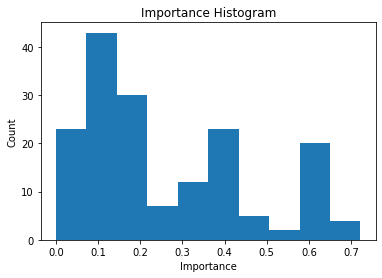

In [95]:
fig = plt.figure()

plt.hist(importances)
plt.xlabel("Importance")
plt.ylabel("Count")
plt.title("Importance Histogram")

path = os.path.join(output_path, "ImportanceHistogram.png")
fig.savefig(path, facecolor="white", transparent=False)
plt.show()

In [96]:
more_important = np.argmax(importances)
memory_stream[more_important]

{'type': 'reflection',
 'created': 1704106800.0,
 'description': 'Alex is warmth and enthusiasm for life are evident in everything he does, making him a beloved presence in his community.',
 'last_acessed': 1719498058.5,
 'embedding': [],
 'importance': 0.7222222222222222,
 'index': 6,
 'influences': [8, 10, 11, 14, 26, 38],
 'because_of': []}

In [97]:
place_hist = []
places = set()
for log in logs:
    places.add(log["current_place"])
    place_hist.append(log["current_place"])

In [98]:
places_list = list(places)

<ipython-input-99-db949991f286>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


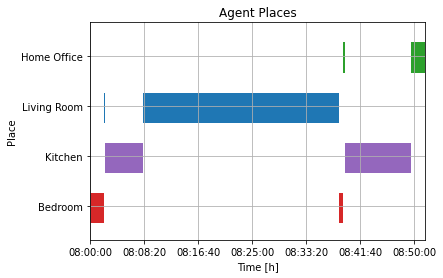

In [99]:
fig, ax = plt.subplots()

plt.title("Agent Places")

ax.set_xlabel('Time [h]')
ax.set_ylabel('Place')

ax.set_ylim(0, 65)
ax.set_xlim(logs[0]["agent_time"], 1719489100)

x_ticks = ax.get_xticks()
labels = [format_timestamp(x) for x in x_ticks]
ax.set_xticklabels(labels)

ax.set_yticks([10, 25, 40, 55])
ax.set_yticklabels(places_list)
  

ax.grid(True)

#text_up = [False, False, False, False]

for i, log in enumerate(logs):
    place = log["current_place"]
    
    if place == places_list[0]:
        line_range = (5,9)
        color = "red"
    elif place == places_list[1]:
        line_range = (20,9)
        color = "purple"
    elif place == places_list[2]:
        line_range = (35,9)
        color = "blue"
    else:
        line_range = (50,9)
        color = "green"

    start = log["agent_time"]
    if i == len(logs)-1:
        duration = 0
    else:
        duration = logs[i+1]["agent_time"]-start

    ax.broken_barh([(start, duration)], line_range, facecolors=('tab:'+color))

    text_position = line_range[0]-2.5

path = os.path.join(output_path, "AgentPlaces.png")
fig.savefig(path, facecolor="white", transparent=False, bbox_inches='tight')
plt.show()

In [100]:
actions = set()
action_hist = []

for log in logs:
    actions.add(log["action"])
    action_hist.append(log["action"])

len(actions), len(logs)

(43, 47)

In [101]:
for i, log in enumerate(logs):
    if i != 0:
        previous_log = logs[i-1]
        if log["current_place"] != previous_log["current_place"]:
            previous_time = format_timestamp(previous_log["agent_time"])
            print(previous_time, previous_log["current_place"], "-->", previous_log["action"], "-->", log["current_place"])

08:02:03 Bedroom --> Alex goes to the Living Room to have breakfast --> Living Room
08:02:15 Living Room --> Alex gets up from sofa_0 to prepare for breakfast --> Kitchen
08:08:00 Kitchen --> Alex finishes eating breakfast at dining_table_0 --> Living Room
08:38:14 Living Room --> Alex walks to the bedroom to get dressed for breakfast --> Bedroom
08:38:54 Bedroom --> Alex heads to the Home Office --> Home Office
08:39:08 Home Office --> Alex walks to the Kitchen to prepare breakfast --> Kitchen
08:49:25 Kitchen --> Alex heads to the Home Office --> Home Office


In [102]:
Counter(action_hist).most_common(10)

[('Alex continues editing his photos', 3),
 ('Alex heads to the Home Office', 2),
 ('Alex continues editing photos', 2),
 ('Alex wakes up', 1),
 ('Alex gets out of bed', 1),
 ('Alex starts planning his outfit for the day', 1),
 ('Alex gets dressed', 1),
 ('Alex goes to the Living Room to have breakfast', 1),
 ('Alex sits on the sofa_0', 1),
 ('Alex gets up from sofa_0 to prepare for breakfast', 1)]

In [103]:
start = False
for log in logs:
    if log["action"] == "Alex heads to the Home Office" or start:
        agent_time = log["agent_time"]
        agent_time = datetime.datetime.fromtimestamp(agent_time)

        print(agent_time.strftime("%H:%M:%S"), log["current_place"])
        print("State:", log["state"])
        print("Observation:", log["curret_observation"])
        print("Next action:", log["action"])
        print("----")
        
        if log["action"] == "Alex heads to the Home Office" and start:
            break
        
        start = True


08:38:54 Bedroom
State: fully dressed
Observation: Alex sees the dresser with its drawers slightly ajar, the nightstand with a lamp, the closet which is partially emptied, and the desk with a notebook and pens on top, all nearby. He sees himself in the mirror on the wall, fully dressed. He hears the silence of the bedroom, only slightly disturbed by the sound of his own breathing. He feels the softness of the rug beneath his feet, the freshness of the air, and the comfort of his clothes on his skin.
Next action: Alex heads to the Home Office
----
08:39:04 Home Office
State: moving
Observation: Alex sees the spacious desk in front of him, with dual monitors, laptop, external hard drive, mouse, keyboard, and desk lamp all neatly organized. He notices the ergonomic office chair is empty and clean. To his left, he sees a bookshelf filled with photography books and reference materials. The printer is off and clean on a nearby shelf. The room is quiet, and he feels a gentle breeze from the a

In [104]:
object_names = set()

for room in logs[0]["environment_tree"]["Alex's House"].values():
    for object in room:
        object_names.add(object["name"])

In [105]:
object_states = []

for log in logs:
    state = dict.fromkeys(object_names)
    for room in log["environment_tree"]["Alex's House"].values():
        for object in room:
            state[object["name"]] = object["state"]
    
    object_states.append(state)

In [106]:
object_state_changes = []
object_state_changes.append([])

for i in range(1, len(logs)):
    changes = []
    for object in object_names:
        if object_states[i][object] != object_states[i-1][object]:
            changes.append((object, object_states[i-1][object], object_states[i][object]))

    object_state_changes.append(changes)

In [107]:
for i in range(1, len(logs)):
    print(i, logs[i-1]["action"])
    print(object_state_changes[i])

1 Alex wakes up
[('Alex', 'sleeping in the bed.', 'awake'), ('bed_0', 'idle and clean', 'occupied and messy')]
2 Alex gets out of bed
[('Alex', 'awake', 'standing'), ('bed_0', 'occupied and messy', 'unoccupied and messy')]
3 Alex starts planning his outfit for the day
[('dresser_0', 'idle and clean', 'opened with clothes laid out'), ('closet_0', 'idle and clean', 'in use and partially disorganized')]
4 Alex gets dressed
[('dresser_0', 'opened with clothes laid out', "Alex's dresser with organized clothes, now closed and tidy"), ('Alex', 'standing', 'dressed'), ('closet_0', 'in use and partially disorganized', 'organized and empty')]
5 Alex goes to the Living Room to have breakfast
[]
6 Alex sits on the sofa_0
[('Alex', 'dressed', 'seated'), ('sofa_0', 'idle and clean', 'occupied and clean')]
7 Alex gets up from sofa_0 to prepare for breakfast
[('Alex', 'seated', 'standing'), ('sofa_0', 'occupied and clean', 'vacant and clean')]
8 Alex heads to refrigerator_0 to get ingredients for brea

In [108]:
i = 11

for object_info in object_state_changes[i]:
    print(object_info[0], object_info[1])

print("-->")
print(logs[i-1]["action"])
print("-->")

for object_info in object_state_changes[i]:
    print(object_info[0], object_info[2])

dining_table_0 idle and clean
Alex holding eggs
-->
Alex puts the eggs on the dining_table_0
-->
dining_table_0 with eggs on it
Alex not holding anything


```mermaid
flowchart TD

subgraph dining_table0
    state00["idle and clean"]
    state01["with eggs on it"]
end

action("Alex put the eggs on the dining_table_0")

state00 --> action --> state01
state10 --> action --> state11

subgraph Alex
    state10["holding eggs"]
    state11["not holding anything"]
end
```